In [1]:
from datetime import datetime
import calendar

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error

import tensorflow as tf
import keras

%matplotlib inline

# Classical Statistics

First we use classical statistics, with only house price data, to predict future house prices.

## Data

Here we have data for "simple average house prices, by new/other dwellings, type of buyer and  region, United Kingdom, from 1992 (quarterly)".

From this we want to extract prices for all dwellings. The easiest way to to this is in excel itself. Then import the transformed csv using pandas.

In [2]:
# Define date parser for reading CSV
def date_parser_func(x):
    quarter, year = x.split("-")
    month = int(quarter[1]) * 3
    return pd.Timestamp(int(year), month, calendar.monthrange(int(year), month)[1])

In [3]:
# Import clean CSV as DF
raw_house_price_df = pd.read_csv(
    'CleanData/quarterly_house_prices.csv',
    encoding='utf-8',
    header=0,
    index_col=False,
    parse_dates=[0],
    date_parser=date_parser_func
)

C:\Users\haydn\AppData\Local\Temp\ipykernel_6436\3462159518.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  raw_house_price_df = pd.read_csv(


In [4]:
raw_house_price_df.head(3)

,Quarter,Price
0,1992-06-30,62000
1,1992-09-30,64000
2,1992-12-31,59000


In [5]:
raw_house_price_df.dtypes

Quarter    datetime64[ns]
Price               int64
dtype: object

<Axes: xlabel='Quarter'>

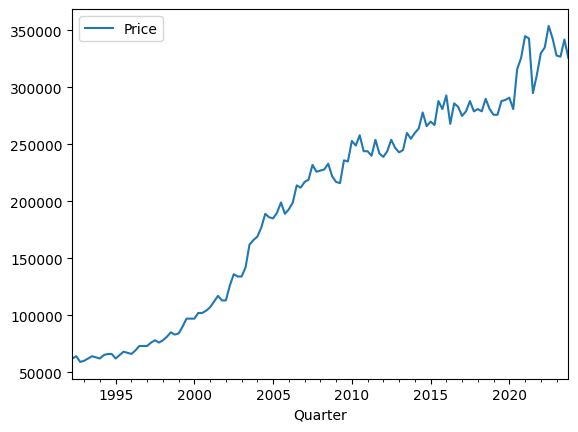

In [6]:
raw_house_price_df.plot(x='Quarter')

## Statistical Analysis

In [7]:
# Use differencing to make series stationary
raw_house_price_df['PriceFirstDiff'] = raw_house_price_df['Price'].diff().dropna()

<Axes: >

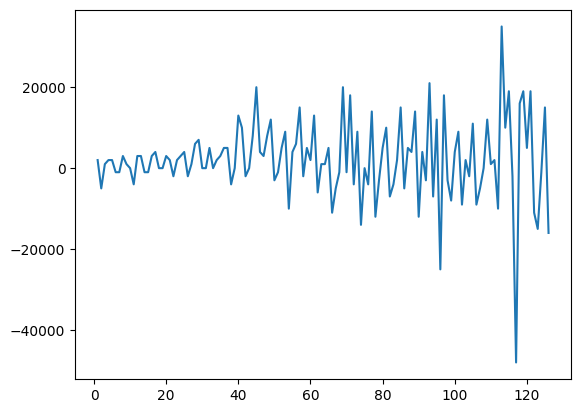

In [8]:
raw_house_price_df['PriceFirstDiff'].plot()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

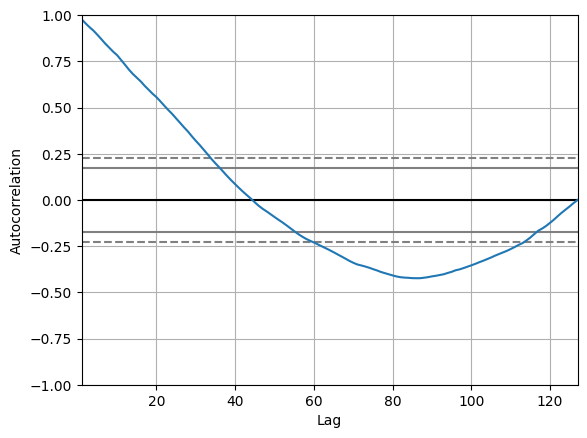

In [9]:
# Autocorrelation
autocorrelation_plot(raw_house_price_df['Price'])

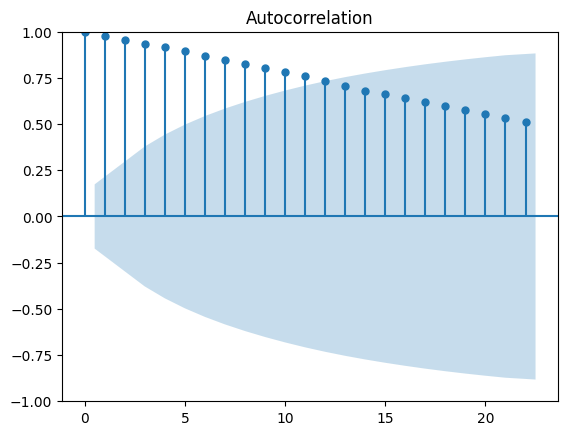

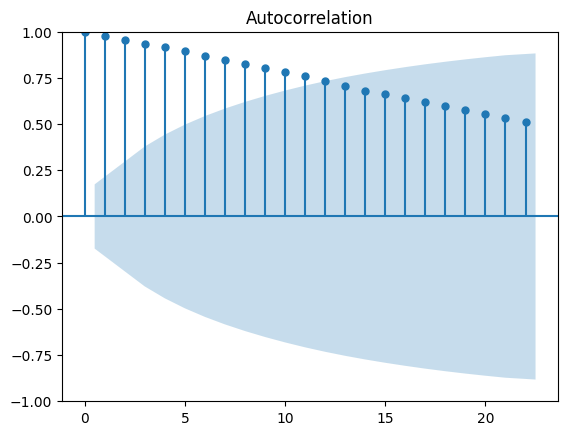

In [10]:
plot_acf(raw_house_price_df['Price'].dropna())

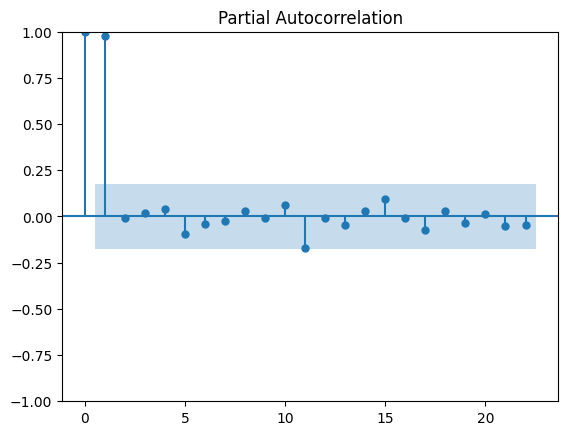

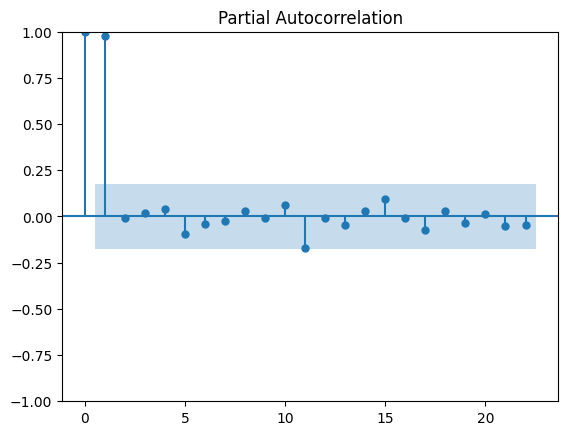

In [11]:
plot_pacf(raw_house_price_df['Price'])

### Finding differencing term

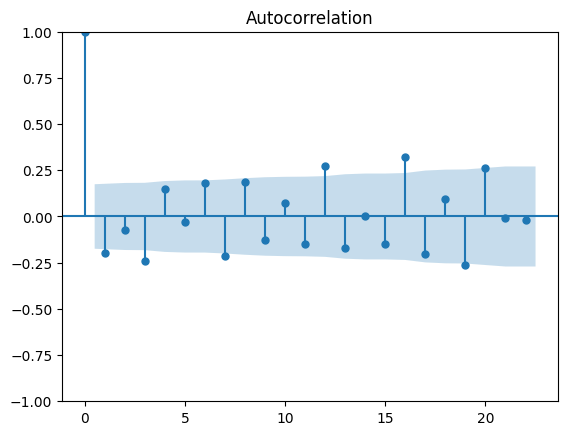

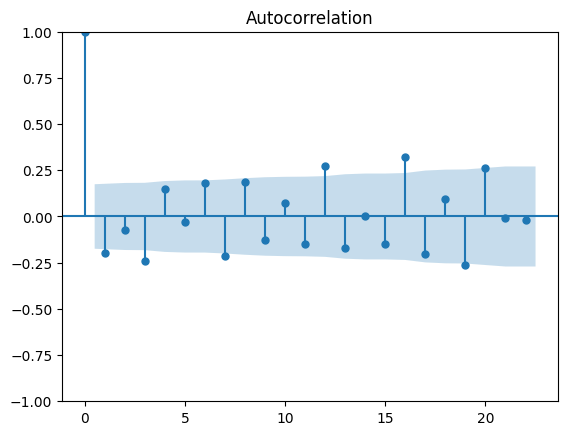

In [12]:
plot_acf(raw_house_price_df['Price'].diff().dropna())

First differencing looks pretty good.

In [13]:
# Verify with statistical test
adfuller(raw_house_price_df['Price'].diff().dropna())[1]

7.473900722749733e-17

Confirmed by miniscule p-value of ADF test.

**d = 1** 

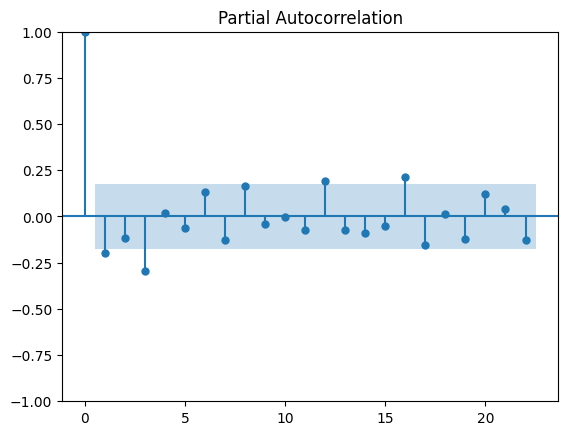

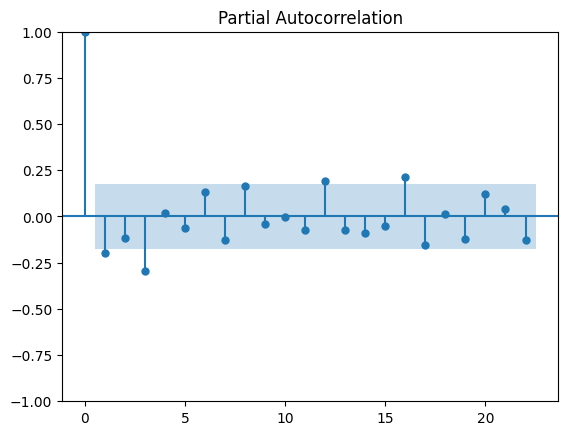

In [14]:
plot_pacf(raw_house_price_df['Price'].diff().dropna())

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

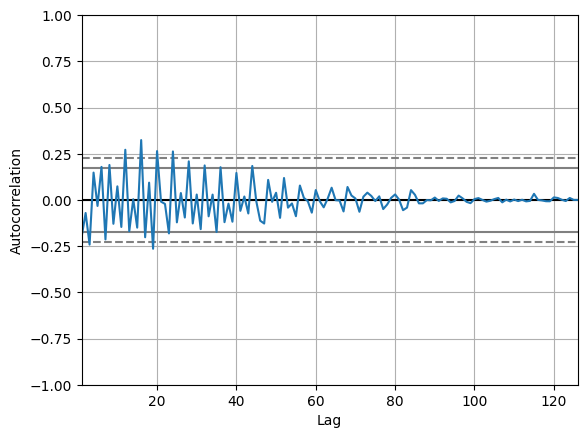

In [15]:
autocorrelation_plot(raw_house_price_df['Price'].diff().dropna())

Not highly significant autocorrelation or partial autocorrelation.

## ARIMA Estimation

In [16]:
# Instantiate the model
arima_model = ARIMA(raw_house_price_df['Price'], order=(1, 1, 0))

In [17]:
# Fit model
arima_model_fit = arima_model.fit()

In [18]:
print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  127
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1338.408
Date:                Mon, 01 Apr 2024   AIC                           2680.815
Time:                        10:00:29   BIC                           2686.488
Sample:                             0   HQIC                          2683.120
                                - 127                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1048      0.077     -1.365      0.172      -0.255       0.046
sigma2      9.866e+07   1.61e-11   6.14e+18      0.000    9.87e+07    9.87e+07
Ljung-Box (L1) (Q):                   1.66   Jarque-

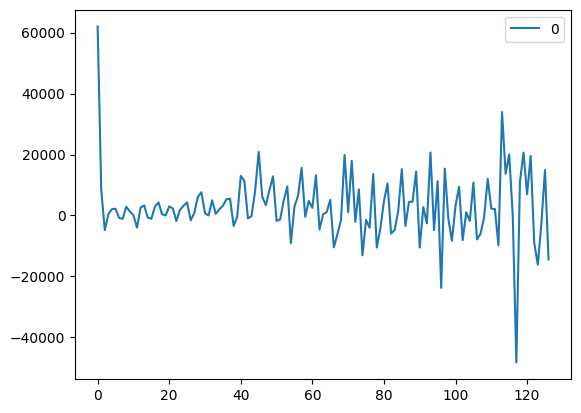

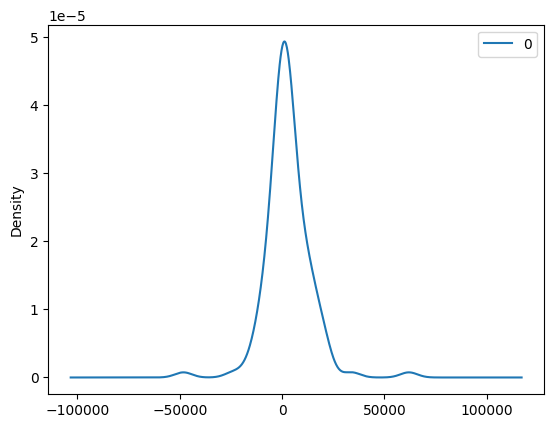

                  0
count    127.000000
mean    2848.692560
std    10997.224567
min   -48209.640107
25%    -1661.439574
50%     2104.820053
75%     7310.250666
max    62000.000000


In [19]:
# line plot of residuals
residuals = pd.DataFrame(arima_model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

### Auto Arima

In [20]:
auto_arima(
    y=raw_house_price_df['Price'],
    seasonal=False,
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2668.614, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2676.943, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2674.899, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2673.960, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2680.602, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2675.344, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2677.981, Time=0.03 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2661.578, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2668.872, Time=0.06 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=2663.528, Time=0.16 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2663.400, Time=0.13 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2661.805, Time=0.08 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=2670.882, Time=0.06 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=2663.316, Time=0.29 sec
 ARIMA(3,1,2)(0,0,0)[0]          

ARIMA(order=(3, 1, 2), scoring_args={}, suppress_warnings=True)

## Rolling ARIMA Forecast

In [21]:
# Get train and test set
X = raw_house_price_df['Price']
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]

In [22]:
train

0      62000
1      64000
2      59000
3      60000
4      62000
       ...  
78    242000
79    239000
80    244000
81    254000
82    247000
Name: Price, Length: 83, dtype: int64

In [23]:
# Fit a model and make a prediction
model = ARIMA(train, order=(0,1,0))
model_fit = model.fit()
model_fit.forecast()

83    247000.0
dtype: float64

In [24]:
# Get feed-forward predictions of all test set
predictions = list()
history = list(train)
future = list(test)
for t in range(len(future)):
    # Make a prediction
    model = ARIMA(history, order=(0,1,0))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    # Add to history
    predictions.append(yhat)
    history.append(yhat)
    print('predicted=%f, expected=%f' % (yhat, future[t]))

predicted=247000.000000, expected=243000.000000
predicted=247000.000000, expected=245000.000000
predicted=247000.000000, expected=260000.000000
predicted=247000.000000, expected=255000.000000
predicted=247000.000000, expected=260000.000000
predicted=247000.000000, expected=264000.000000
predicted=247000.000000, expected=278000.000000
predicted=247000.000000, expected=266000.000000
predicted=247000.000000, expected=270000.000000
predicted=247000.000000, expected=267000.000000
predicted=247000.000000, expected=288000.000000
predicted=247000.000000, expected=281000.000000
predicted=247000.000000, expected=293000.000000
predicted=247000.000000, expected=268000.000000
predicted=247000.000000, expected=286000.000000
predicted=247000.000000, expected=283000.000000
predicted=247000.000000, expected=275000.000000
predicted=247000.000000, expected=279000.000000
predicted=247000.000000, expected=288000.000000
predicted=247000.000000, expected=279000.000000
predicted=247000.000000, expected=281000

Ok that didn't work too well, let's try with auto arima.

In [25]:
# Get feed-forward predictions of all test set
predictions = list()
history = list(train)
future = list(test)
for t in range(len(future)):
    # Make a prediction
    model = ARIMA(history, order=(3,1,2))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    # Add to history
    predictions.append(yhat)
    history.append(yhat)
    print('predicted=%f, expected=%f' % (yhat, future[t]))

predicted=249653.527074, expected=243000.000000
predicted=246546.223383, expected=245000.000000
predicted=250185.875804, expected=260000.000000
predicted=246767.910530, expected=255000.000000
predicted=249891.798312, expected=260000.000000
predicted=246938.696324, expected=264000.000000
predicted=249753.878863, expected=278000.000000
predicted=247083.727105, expected=266000.000000
predicted=249610.466260, expected=270000.000000
predicted=247217.644999, expected=267000.000000
predicted=249485.118825, expected=288000.000000
predicted=247336.620283, expected=281000.000000
predicted=249371.898471, expected=293000.000000
predicted=247443.386207, expected=268000.000000
predicted=249270.585691, expected=286000.000000
predicted=247539.299097, expected=283000.000000
predicted=249179.505230, expected=275000.000000
predicted=247625.095293, expected=279000.000000
predicted=249097.979635, expected=288000.000000
predicted=247702.435133, expected=279000.000000
predicted=249024.883511, expected=281000

Predictions are still terrible. Caused by increasing variance in data - changes in house prices are getting absolutely larger.

ARIMA doesn't work well in these instances. Machine learning (using percentage change) would work better.

# Classical ML

## Data

In [26]:
# Start with same df
raw_house_price_df.head(3)

,Quarter,Price,PriceFirstDiff
0,1992-06-30,62000,NaN
1,1992-09-30,64000,2000.0
2,1992-12-31,59000,-5000.0


In [27]:
# Replace difference column with pct change column
ml_df = raw_house_price_df.copy()
ml_df.drop('PriceFirstDiff', axis=1, inplace=True)
ml_df['PricePctDiff'] = ml_df['Price'].pct_change().dropna()

In [28]:
ml_df.head(3)

,Quarter,Price,PricePctDiff
0,1992-06-30,62000,NaN
1,1992-09-30,64000,0.032258
2,1992-12-31,59000,-0.078125


We transform the other data sets in excel so they can be imported and joined to this df.

Note there are several issues with these data sets that we will ignore. For example, CPI growth is annual whereas GDP growth is quarterly. There is also a question as to how to deal with interest rates (growth rate or leave as raw).

In [29]:
# Import clean CSV as DF
raw_cpi_growth_df = pd.read_csv(
    'CleanData/quarterly_annual_cpi_growth.csv',
    encoding='utf-8',
    header=0,
    index_col=False,
    parse_dates=[0],
    date_parser=date_parser_func
)

C:\Users\haydn\AppData\Local\Temp\ipykernel_6436\2210862531.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  raw_cpi_growth_df = pd.read_csv(


In [30]:
# Import clean CSV as DF
raw_interest_rates_df = pd.read_csv(
    'CleanData/quarterly_interest_rates.csv',
    encoding='utf-8',
    header=0,
    index_col=False,
    parse_dates=[0],
    date_parser=date_parser_func
)

C:\Users\haydn\AppData\Local\Temp\ipykernel_6436\2604845219.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  raw_interest_rates_df = pd.read_csv(


In [31]:
# Import clean CSV as DF
raw_gdp_growth_df = pd.read_csv(
    'CleanData/quarterly_quarterly_gdp_growth.csv',
    encoding='utf-8',
    header=0,
    index_col=False,
    parse_dates=[0],
    date_parser=date_parser_func
)

C:\Users\haydn\AppData\Local\Temp\ipykernel_6436\890239459.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  raw_gdp_growth_df = pd.read_csv(


In [32]:
# Join datasets
join_df_list = [
    raw_cpi_growth_df,
    raw_interest_rates_df,
    raw_gdp_growth_df
]
for df in join_df_list:
    ml_df = ml_df.merge(df, on='Quarter', how='inner')

In [33]:
ml_df.head(3)

,Quarter,Price,PricePctDiff,CPIGrowth,InterestRate,GDPGrowth
0,1992-06-30,62000,NaN,5.0,9.88,-0.2
1,1992-09-30,64000,0.032258,4.0,8.88,0.5
2,1992-12-31,59000,-0.078125,3.3,7.88,0.8


In [34]:
# Drop irrelevant cols
ml_df.drop(['Quarter', 'Price'], axis=1, inplace=True)
# Create target column
ml_df['HousePriceGrowth'] = ml_df['PricePctDiff'].apply(lambda x: x*100)
# Drop reduntant PricePctDiff col
ml_df.drop(['PricePctDiff'], axis=1, inplace=True)
# Remove first row
ml_df = ml_df[1:]

In [35]:
ml_df.head(3)

,CPIGrowth,InterestRate,GDPGrowth,HousePriceGrowth
1,4.0,8.88,0.5,3.225806
2,3.3,7.88,0.8,-7.812500
3,3.1,5.88,0.5,1.694915


## EDA

In [36]:
ml_df.dtypes

CPIGrowth           float64
InterestRate        float64
GDPGrowth           float64
HousePriceGrowth    float64
dtype: object

In [37]:
ml_df.describe()

,CPIGrowth,InterestRate,GDPGrowth,HousePriceGrowth
count,126.000000,126.000000,126.000000,126.000000
mean,2.415079,3.507619,0.508730,1.415126
std,1.587303,2.353114,2.521238,4.257402
min,0.300000,0.250000,-20.300000,-13.994169
25%,1.500000,1.500000,0.300000,-1.487050
50%,2.150000,4.375000,0.600000,1.479152
75%,2.700000,5.500000,0.800000,4.525162
max,9.400000,8.880000,16.800000,14.084507


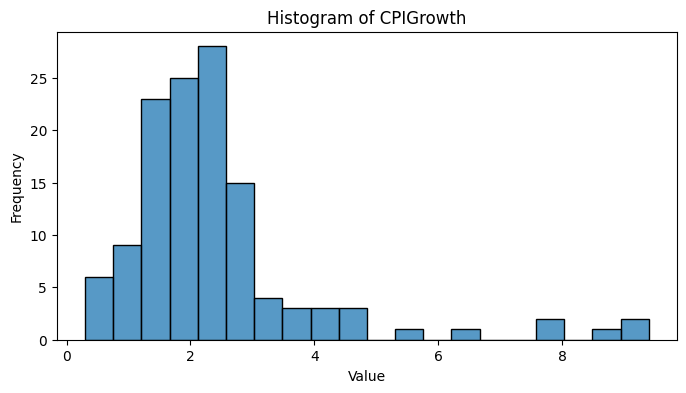

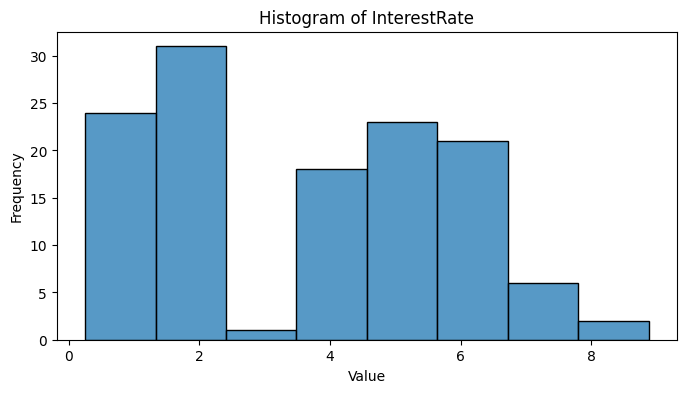

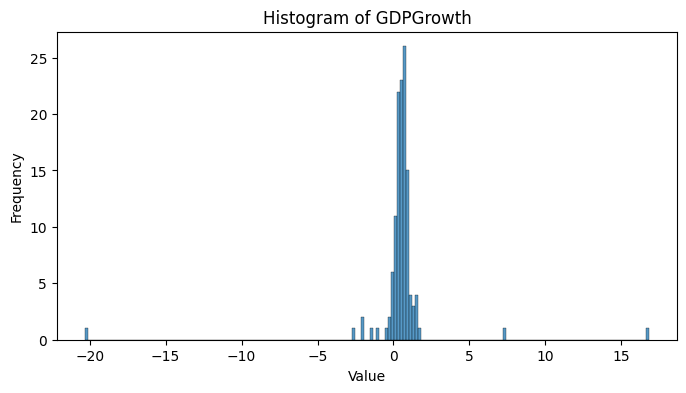

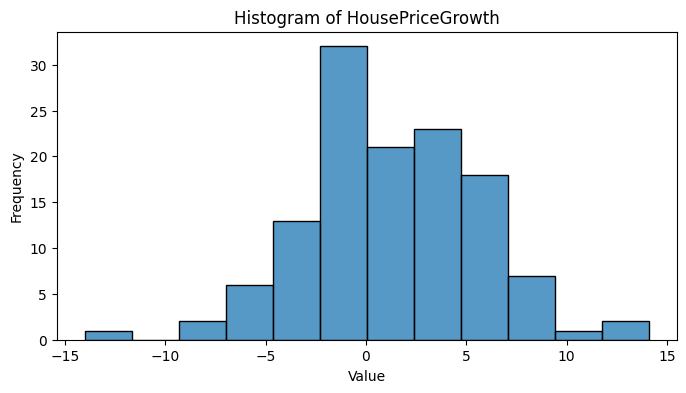

In [38]:
for column in ml_df.columns:
    plt.figure(figsize=(8, 4))  # Set the size of each subplot
    sns.histplot(ml_df[column], kde=False)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column}')
    plt.show()

<Axes: >

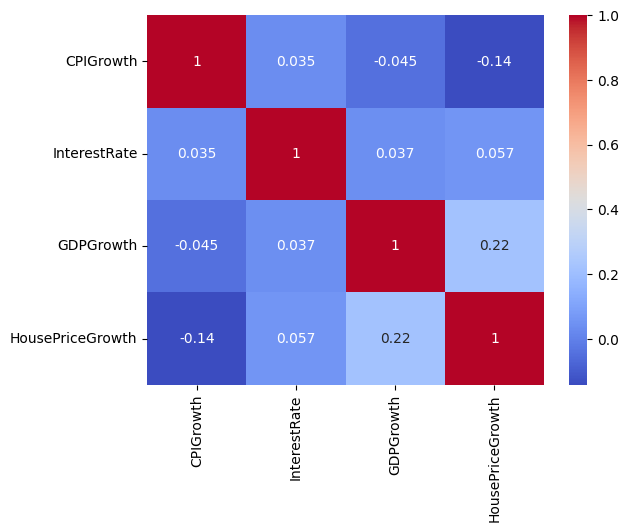

In [39]:
sns.heatmap(ml_df.corr(), annot=True, cmap="coolwarm")

<Axes: >

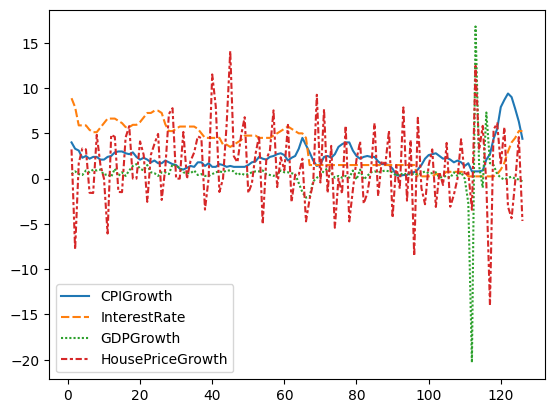

In [40]:
sns.lineplot(data=ml_df)

## Linear Regression

### Feature Engineering

In [41]:
# Copy df to test some feature eng
feat_eng_df = ml_df.copy()

In [42]:
# Create lagged variables
for column in ml_df.columns:
    for lag in range(1, 5):
        feat_eng_df[f"{column}_lag_{lag}"] = feat_eng_df[column].shift(lag)

In [43]:
feat_eng_df.head(3)

,CPIGrowth,InterestRate,GDPGrowth,HousePriceGrowth,CPIGrowth_lag_1,CPIGrowth_lag_2,CPIGrowth_lag_3,CPIGrowth_lag_4,InterestRate_lag_1,InterestRate_lag_2,InterestRate_lag_3,InterestRate_lag_4,GDPGrowth_lag_1,GDPGrowth_lag_2,GDPGrowth_lag_3,GDPGrowth_lag_4,HousePriceGrowth_lag_1,HousePriceGrowth_lag_2,HousePriceGrowth_lag_3,HousePriceGrowth_lag_4
1,4.0,8.88,0.5,3.225806,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.3,7.88,0.8,-7.812500,4.0,NaN,NaN,NaN,8.88,NaN,NaN,NaN,0.5,NaN,NaN,NaN,3.225806,NaN,NaN,NaN
3,3.1,5.88,0.5,1.694915,3.3,4.0,NaN,NaN,7.88,8.88,NaN,NaN,0.8,0.5,NaN,NaN,-7.812500,3.225806,NaN,NaN


In [44]:
# Drop current features
feat_eng_df.drop(['CPIGrowth', 'InterestRate', 'GDPGrowth'], axis=1, inplace=True)
# Drop null rows
lin_model_df = feat_eng_df[4:]

In [45]:
# Make a generic function that does the above
# i.e. creates 4-quarter lag features of all input features
def create_q_lag_feats (df, target_col, drop_nulls):
    # Col list to drop
    drop_list = []
    for column in df.columns:
        # Drop current feature cols
        if column != target_col:
            drop_list.append(column)
        for lag in range(1, 5):
            df[f"{column}_lag_{lag}"] = df[column].shift(lag)
    # Drop columns
    df.drop(drop_list, axis=1, inplace=True)
    # Add functionality to drop nulls as a result of lagging
    if drop_nulls:
        return df[4:]
    else:
        return df

### Modelling

In [46]:
add_feat_df = lin_model_df.copy()

In [47]:
# Define X and y
X = add_feat_df.drop(columns=['HousePriceGrowth'])
y = add_feat_df['HousePriceGrowth']
# Split data to train, test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [48]:
X_train.head(3)

,CPIGrowth_lag_1,CPIGrowth_lag_2,CPIGrowth_lag_3,CPIGrowth_lag_4,InterestRate_lag_1,InterestRate_lag_2,InterestRate_lag_3,InterestRate_lag_4,GDPGrowth_lag_1,GDPGrowth_lag_2,GDPGrowth_lag_3,GDPGrowth_lag_4,HousePriceGrowth_lag_1,HousePriceGrowth_lag_2,HousePriceGrowth_lag_3,HousePriceGrowth_lag_4
5,2.3,3.1,3.3,4.0,5.88,5.88,7.88,8.88,0.4,0.5,0.8,0.5,3.333333,1.694915,-7.812500,3.225806
6,2.5,2.3,3.1,3.3,5.88,5.88,5.88,7.88,0.9,0.4,0.5,0.8,3.225806,3.333333,1.694915,-7.812500
7,2.2,2.5,2.3,3.1,5.38,5.88,5.88,5.88,0.7,0.9,0.4,0.5,-1.562500,3.225806,3.333333,1.694915


In [49]:
# Fit linear regression to transformed data
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

0.5238176384478824
2.733817121544573


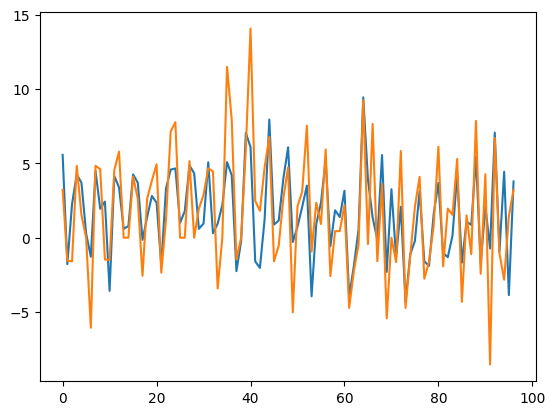

In [50]:
# How good was the fit?
lin_train_preds = model.predict(X_train)
print(model.score(X_train, y_train))
print(root_mean_squared_error(lin_train_preds, y_train))
plt.plot(lin_train_preds)
plt.plot(np.array(y_train))

In [51]:
# Checkign the coefficients
coef_df = pd.DataFrame(
    {
        'Feature': list(X_train.columns),
        'Coefficient': list(model.coef_)
    }
)

In [52]:
coef_df

,Feature,Coefficient
0,CPIGrowth_lag_1,-0.233348
1,CPIGrowth_lag_2,-0.578383
2,CPIGrowth_lag_3,-0.305131
3,CPIGrowth_lag_4,0.363446
4,InterestRate_lag_1,0.395108
5,InterestRate_lag_2,-0.586815
6,InterestRate_lag_3,-0.091129
7,InterestRate_lag_4,0.670850
8,GDPGrowth_lag_1,1.733479
9,GDPGrowth_lag_2,-0.665237


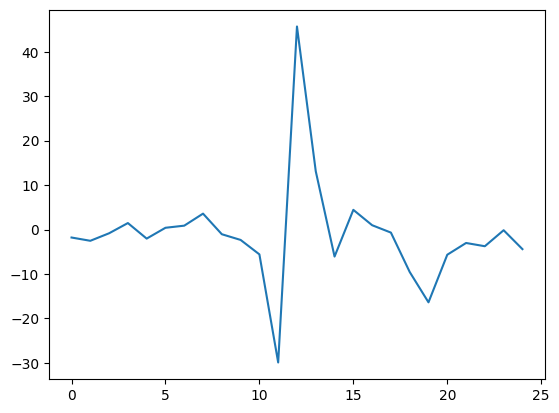

In [53]:
# Make predictions
lin_preds = model.predict(X_test)
plt.plot(lin_preds)

In [54]:
lin_preds

array([ -1.79800928,  -2.53643637,  -0.84383665,   1.4553831 ,
        -2.04231932,   0.3932562 ,   0.86892113,   3.5770154 ,
        -1.05838704,  -2.34187946,  -5.59213267, -29.92119791,
        45.69559702,  13.11416177,  -6.08314448,   4.42800576,
         0.97180345,  -0.69109574,  -9.5513688 , -16.38355143,
        -5.67317363,  -3.02843646,  -3.75965313,  -0.16010036,
        -4.40998739])

In [55]:
np.array(y_test)

array([ -3.125     ,   0.71684588,  -0.71174377,   3.94265233,
        -3.10344828,  -1.77935943,   0.        ,   4.34782609,
         0.34722222,   0.69204152,  -3.43642612,  12.45551601,
         3.16455696,   5.82822086,  -0.57971014, -13.9941691 ,
         5.42372881,   6.10932476,   1.51515152,   5.67164179,
        -3.10734463,  -4.37317784,  -0.30487805,   4.58715596,
        -4.67836257])

13.837480471344845


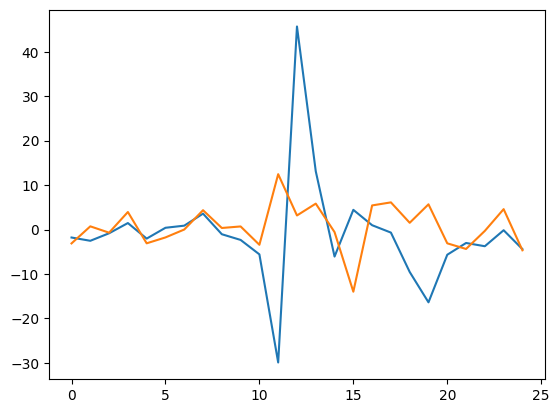

In [56]:
# Are they any good?
print(root_mean_squared_error(lin_preds, y_test))
plt.plot(lin_preds)
plt.plot(np.array(y_test))

"Anomolies" in the test set causing carnage. That's the game.

# Neural Network

## Data Prep

In [57]:
ml_df.head(3)

,CPIGrowth,InterestRate,GDPGrowth,HousePriceGrowth
1,4.0,8.88,0.5,3.225806
2,3.3,7.88,0.8,-7.812500
3,3.1,5.88,0.5,1.694915


In [58]:
len(ml_df)

126

LSTM needs to be fed a list of previosu values from which to predict target values in time t.

Here the window defined will be of 5 years (20 quarters). Meaning that each sample that the model will use to learn from will consist of values of the training features in the time t-20, t-19, ..., t-1 to predict the y value in t:

Sample example: [[[CPIGrowth(t-20), InterestRate(t-20), GDPGrowth(t-20)],
                  [[CPIGrowth(t-19), InterestRate(t-19), GDPGrowth(t-19)],
                  ...
                  [CPIGrowth(t-1), InterestRate(t-1), GDPGrowth(t-1)]],
                  [HousePriceGrowth(t)]

In [59]:
# Data splitting
lstm_df = ml_df[6:].reset_index().drop('index', axis=1)  # To divisible df
# Define X and y
X = lstm_df.drop(columns=['HousePriceGrowth'])
y = lstm_df['HousePriceGrowth']

In [60]:
# Single step dataset preparation
def single_step_sampler(X_data, y_data, window):
    xRes = []
    yRes = []
    for i in range(0, len(X_data) - window):
        res = []
        for j in range(0, window):
            r = []
            for col in X_data.columns:
                r.append(X_data[col][i + j])
            res.append(r)
        xRes.append(res)
        yRes.append(y_data[i + window])
    return np.array(xRes), np.array(yRes)

#### Seeing if it worked

In [61]:
ss_test_X, ss_test_y = single_step_sampler(X, y, 20)

In [62]:
ss_test_X[0]

array([[2.4 , 5.13, 1.  ],
       [2.4 , 5.13, 0.9 ],
       [2.1 , 5.63, 1.  ],
       [2.1 , 6.13, 0.4 ],
       [2.4 , 6.63, 0.5 ],
       [2.5 , 6.63, 0.2 ],
       [2.9 , 6.63, 1.1 ],
       [3.  , 6.38, 0.3 ],
       [3.  , 6.13, 0.7 ],
       [2.8 , 5.69, 0.3 ],
       [2.7 , 5.69, 0.9 ],
       [2.9 , 5.94, 1.4 ],
       [2.4 , 5.94, 1.6 ],
       [2.1 , 6.25, 1.1 ],
       [2.3 , 6.75, 0.9 ],
       [2.1 , 7.25, 1.5 ],
       [1.8 , 7.25, 0.7 ],
       [2.  , 7.5 , 0.6 ],
       [1.7 , 7.5 , 0.3 ],
       [1.7 , 7.25, 0.7 ]])

In [63]:
ss_test_y[0]

1.2048192771084265

In [64]:
lstm_df.iloc[0]

CPIGrowth           2.400000
InterestRate        5.130000
GDPGrowth           1.000000
HousePriceGrowth   -1.587302
Name: 0, dtype: float64

In [65]:
lstm_df.iloc[20]

CPIGrowth           2.000000
InterestRate        6.000000
GDPGrowth           0.700000
HousePriceGrowth    1.204819
Name: 20, dtype: float64

In [66]:
len(ss_test_X)

100

In [67]:
len(ss_test_y)

100

In [68]:
len(X)

120

Seems like it worked correctly.

## Train an Overfit Model

In [69]:
# Dataset splitting
(xVal, yVal) = single_step_sampler(X, y, 20)
X_train = xVal[:90]
y_train = yVal[:90]
X_test = xVal[90:]
y_test = yVal[90:]

In [70]:
# Verify shape
X_train.shape

(90, 20, 3)

In [71]:
# Create model for training
multivariate_lstm = keras.Sequential()
multivariate_lstm.add(keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2])))
multivariate_lstm.add(keras.layers.LSTM(units=64))
multivariate_lstm.add(keras.layers.Dropout(0.2))
multivariate_lstm.add(keras.layers.Dense(1, activation='linear'))
multivariate_lstm.compile(loss='mean_squared_error', metrics=['MeanSquaredError'], optimizer='Adam')
multivariate_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          17,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,473 (68.25 KB)

 Trainable params: 17,473 (68.25 KB)

 Non-trainable params: 0 (0.00 B)

In [72]:
# (Over)Fit the model
multivariate_lstm.fit(X_train, y_train, epochs=1000)

Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - MeanSquaredError: 25.9423 - loss: 25.7470
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - MeanSquaredError: 20.0939 - loss: 20.1783 
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - MeanSquaredError: 18.1441 - loss: 18.2150 
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - MeanSquaredError: 17.2302 - loss: 17.1317 
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - MeanSquaredError: 16.4954 - loss: 16.5929 
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - MeanSquaredError: 17.6068 - loss: 17.5383 
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - MeanSquaredError: 17.0371 - loss: 16.9794 
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - MeanSquaredError: 16.4131 - loss: 16.6068 
Epoch 9/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - MeanSquaredError: 15.5042 - loss: 15.6826 
Epoch 10/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - MeanSquaredError: 15.4609 - loss: 15.5445 
Epoch 11/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/ste

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


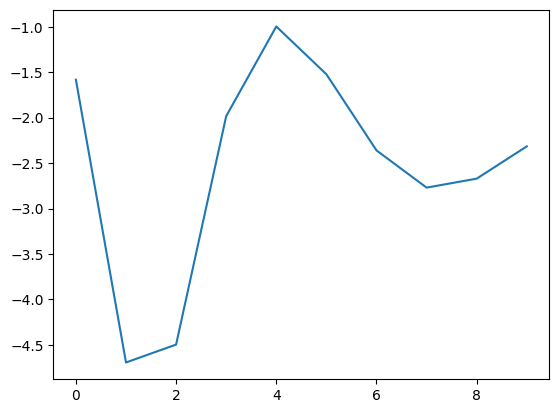

In [73]:
# Make predictions
multivariate_lstm_preds = multivariate_lstm.predict(X_test)
plt.plot(multivariate_lstm_preds)

7.046359930120484


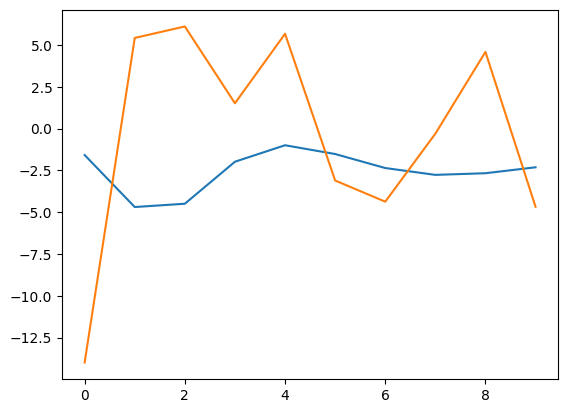

In [74]:
# Are they any good?
print(root_mean_squared_error(multivariate_lstm_preds, y_test))
plt.plot(multivariate_lstm_preds)
plt.plot(y_test)

Model has learned to essentially predict the average (I'm guessing) of the past observations.

## Regularisation and Validation to Reduce Overfit

In [75]:
# Get validation set
X_val_train = X_train[:60]
y_val_train = y_train[:60]
X_val_test = X_train[60:]
y_val_test = y_train[60:]

In [76]:
# Create model for training
robust_multivariate_lstm = keras.Sequential()
robust_multivariate_lstm.add(keras.layers.Input(shape=(X_val_train.shape[1], X_val_train.shape[2])))
robust_multivariate_lstm.add(keras.layers.LSTM(units=64))
robust_multivariate_lstm.add(keras.layers.Dropout(0.2))
robust_multivariate_lstm.add(keras.layers.Dense(1, activation='linear'))
robust_multivariate_lstm.compile(loss='mean_squared_error', metrics=['MeanSquaredError'], optimizer='Adam')
robust_multivariate_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 64)                  │          17,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,473 (68.25 KB)

 Trainable params: 17,473 (68.25 KB)

 Non-trainable params: 0 (0.00 B)

In [77]:
# Fit the model with 1000 epochs as above
history = robust_multivariate_lstm.fit(x=X_val_train, y=y_val_train, validation_data=(X_val_test, y_val_test), epochs=1000)

Epoch 1/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 391ms/step - MeanSquaredError: 18.0364 - loss: 18.1643 - val_MeanSquaredError: 18.1733 - val_loss: 18.1733
Epoch 2/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - MeanSquaredError: 17.0749 - loss: 17.2397 - val_MeanSquaredError: 18.0486 - val_loss: 18.0486
Epoch 3/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - MeanSquaredError: 18.0293 - loss: 17.9852 - val_MeanSquaredError: 18.0215 - val_loss: 18.0215
Epoch 4/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - MeanSquaredError: 18.1910 - loss: 18.0322 - val_MeanSquaredError: 18.0647 - val_loss: 18.0647
Epoch 5/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - MeanSquaredError: 17.3030 - loss: 17.2387 - val_MeanSquaredError: 18.1490 - val_loss: 18.1490
Epoch 6/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - MeanSquaredError: 18.1153 - loss: 17.8931 - val_MeanSquaredError: 18.2436 - val_loss: 18.2436
Epoch 7/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - MeanSquaredError: 17.0012 - loss: 16.9562 - val_MeanSquaredError

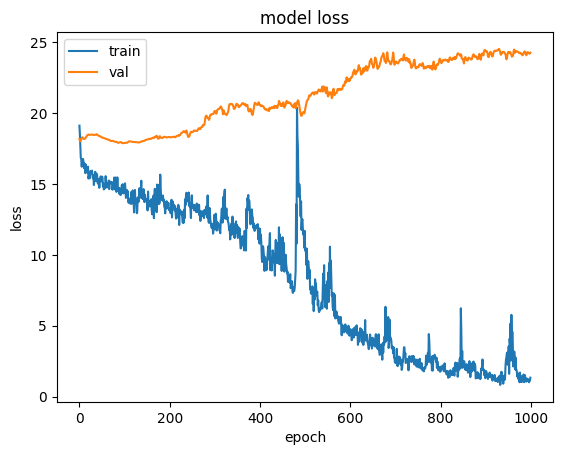

In [78]:
# Plot loss history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Validation loss not changing.

Unsurprisingly, the model is struggling to predict house price growth.